# Few Shot Node Classification w/ Simple Graph Convolution (SGC) Graph Network Architecture

## I. Initial dataset prep

### Download and import libraries for graph learning

In [65]:
#!pip install dgl
#!pip install torch

In [66]:
import dgl
import torch
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from dgl.nn import GraphConv

### Download the dataset

In [67]:
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [68]:
# Let's examine the number of distinct node classes
print(torch.unique(g.ndata['label']))
print(torch.bincount(g.ndata['label']))

tensor([0, 1, 2, 3, 4, 5, 6])
tensor([351, 217, 418, 818, 426, 298, 180])


## II. Model prep

### Create an SGC model

In [69]:
class SGC(nn.Module):
    """
    Simple Graph Convolution model with two layers.

    SGC models do not have a non-linearity between graph layers,
    but they do have weight matrices involved in message passing.
    """
    def __init__(self, in_feats, h_feats, num_classes):
        super(SGC, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats, 
                               weight = True, bias = False, activation = None)
        self.conv2 = GraphConv(h_feats, num_classes,
                               weight = True, bias = False, activation = None)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

### Helper function for creating tasks from nodes

In [70]:
# Sample num_shots nodes from a given class
def gen_task(g, label_num, num_shots):
    indices = torch.flatten(torch.nonzero(g.ndata['label'] == label_num))
    num_indices = len(indices)

    train_shots = np.random.choice(num_indices, num_shots)
    test_nodes = np.delete(indices, train_shots)
    train_shots = indices[train_shots]

    return train_shots, test_nodes

### Create the 1, 2, and 3-shot test tasks for the test classes

In [71]:
test_classes = (1, 5)
num_runs = 50

one_shot_runs = []
two_shot_runs = []
three_shot_runs = []

for j in range(num_runs):
    # Generate the 1 shot tasks
    one_shot_train_list = []
    one_shot_test_list = []
    for i, class_lab in enumerate(test_classes): 
        cur_train_shots, cur_test_nodes = gen_task(g, label_num = class_lab, 
                                                    num_shots = 1)
        one_shot_train_list.append(cur_train_shots)
        one_shot_test_list.append(cur_test_nodes)

    # Generate the 2 shot tasks
    two_shot_train_list = []
    two_shot_test_list = []
    for i, class_lab in enumerate(test_classes): 
        cur_train_shots, cur_test_nodes = gen_task(g, label_num = class_lab, 
                                                    num_shots = 2)
        two_shot_train_list.append(cur_train_shots)
        two_shot_test_list.append(cur_test_nodes)

    # Generate the 3 shot tasks
    three_shot_train_list = []
    three_shot_test_list = []
    for i, class_lab in enumerate(test_classes): 
        cur_train_shots, cur_test_nodes = gen_task(g, label_num = class_lab, 
                                                    num_shots = 3)
        three_shot_train_list.append(cur_train_shots)
        three_shot_test_list.append(cur_test_nodes)

    # Append to the runs
    one_shot_runs.append((one_shot_train_list, one_shot_test_list))
    two_shot_runs.append((two_shot_train_list, two_shot_test_list))
    three_shot_runs.append((three_shot_train_list, three_shot_test_list))

## III. Traditional graph learning

### Create a training loop for traditional graph learning

In [72]:
# Provided test set query classes 
def training_loop(num_shots, num_epochs, classes, num_ways, 
                  train_shots, test_nodes):  

    if len(classes) != num_ways:
      print("Number of classes provided does not equal desired number"
            "of classes for classification task")
      raise ValueError

    model = SGC(g.ndata['feat'].shape[1], 64, 2)
  
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    features = torch.clone(g.ndata['feat'])
    labels = torch.clone(g.ndata['label'])

    # Relabel the classes, obtain training shots
    for i, class_lab in enumerate(classes): 
      labels[g.ndata['label']==class_lab] = i

    # Save accuracy values
    best_val_acc = 0
    best_test_acc = 0
    train_accs = []
    test_accs = []

    # Get all training shots and query examples
    all_shots = np.concatenate(train_shots)
    all_query = np.concatenate(test_nodes)

    for epoch in range(num_epochs):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss for the given shots 
        loss = F.cross_entropy(logits[all_shots], labels[all_shots])

        # Compute accuracy on training/validation/test
        train_acc = (pred[all_shots] == labels[all_shots]).float().mean()
        test_acc = (pred[all_query] == labels[all_query]).float().mean()

        # Save the training and test accs
        train_accs.append(train_acc.item())
        test_accs.append(test_acc.item())

        # Save the best validation accuracy and the corresponding test accuracy
        if best_test_acc < test_acc:
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return train_accs, test_accs, best_test_acc

### Input hyperparameters, run traditional graph learning for a 2-way, 1-shot task

In [73]:
# Input parameters here
num_shots = 1
num_ways = 2
num_training_epochs = 100

In [74]:
# Save the evolution of training, test accuracies, best overall test accuracy,
# and terminal test accuracy for the specified number of runs

all_train_accs = []
all_test_accs = []
best_test_accs = []
terminal_test_accs = []

for i in range(num_runs):
    cur_train_accs, cur_test_accs, cur_best_acc = training_loop(num_shots, num_training_epochs, 
                                                                test_classes, num_ways, 
                                                                train_shots = one_shot_runs[i][0], 
                                                                test_nodes = one_shot_runs[i][1])
    
    all_train_accs.append(cur_train_accs)
    all_test_accs.append(cur_test_accs)
    best_test_accs.append(cur_best_acc)
    terminal_test_accs.append(cur_test_accs[-1])

### Create plots and metrics for the 2-way, 1-shot task

/tmp/ipykernel_28453/4167386516.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


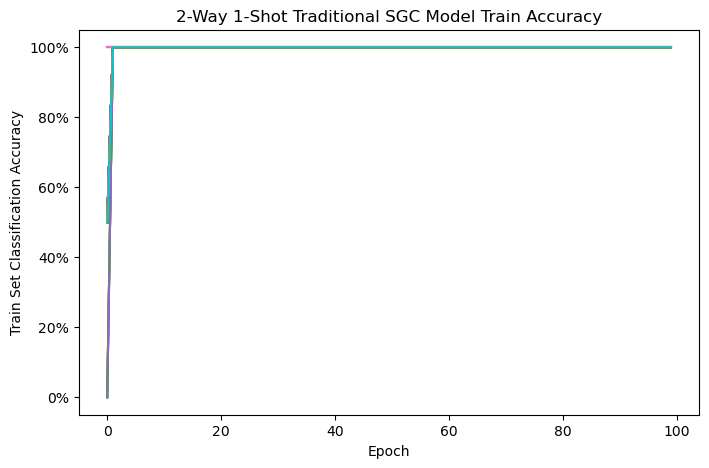

In [75]:
# Plot evolution of training accuracy
plt.figure(figsize=(8,5))
for lst in all_train_accs:
    plt.plot(lst)

plt.title("{}-Way {}-Shot Traditional SGC Model Train Accuracy".format(num_ways, num_shots))
plt.xlabel("Epoch")
plt.ylabel("Train Set Classification Accuracy")
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 

plt.show()

/tmp/ipykernel_28453/4202757991.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


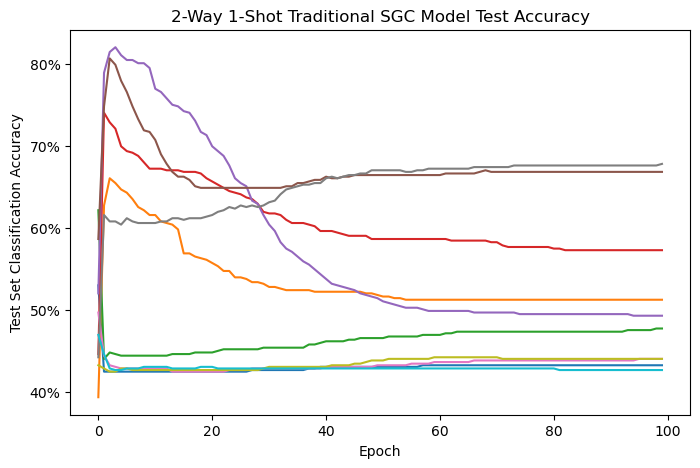

In [76]:
# Plot evolution of test accuracy 
plt.figure(figsize=(8,5))
for lst in all_test_accs[:10]:
    plt.plot(lst)

plt.title("{}-Way {}-Shot Traditional SGC Model Test Accuracy".format(num_ways, num_shots))
plt.xlabel("Epoch")
plt.ylabel("Test Set Classification Accuracy")
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 

plt.show()

/tmp/ipykernel_28453/2378589325.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


Text(0.5632077586650849, 14.175, 'Mean: 65.5%')

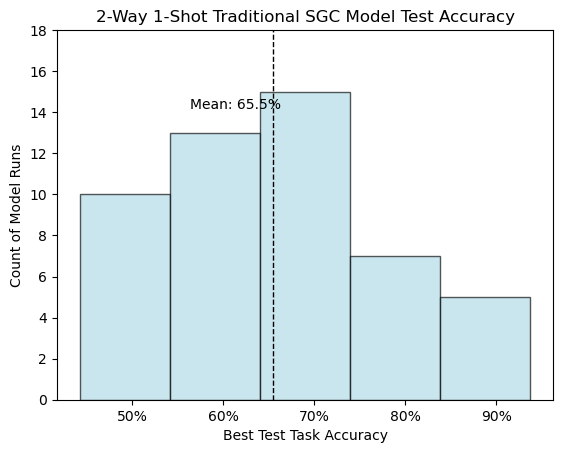

In [77]:
# Plot histogram of best accuracy achieved with mean
best_test_accs = np.array(best_test_accs)

result = plt.hist(best_test_accs, bins=5, color='lightblue', edgecolor='k', alpha=0.65)
plt.axvline(best_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

plt.title("{}-Way {}-Shot Traditional SGC Model Test Accuracy".format(num_ways, num_shots))
plt.xlabel("Best Test Task Accuracy")
plt.ylabel("Count of Model Runs")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0,20,2))
plt.text(best_test_accs.mean()*0.86, max_ylim*0.9, 
         'Mean: {:.1%}'.format(best_test_accs.mean()))

/tmp/ipykernel_28453/1805844587.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


Text(0.48304873287677763, 17.009999999999998, 'Mean: 58.9%')

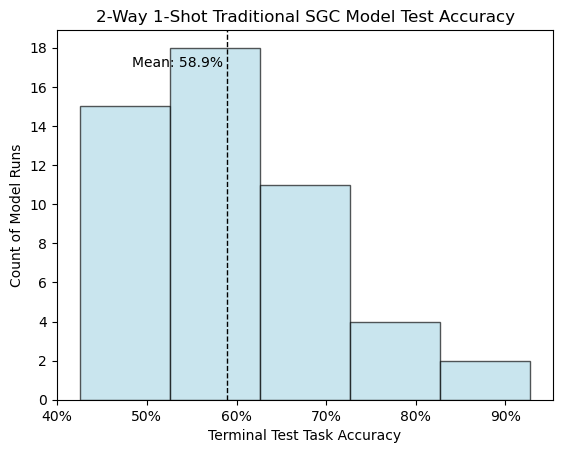

In [78]:
# Plot histogram of terminal accuracy achieved with mean
terminal_test_accs = np.array(terminal_test_accs)

result = plt.hist(terminal_test_accs, bins=5, color='lightblue', edgecolor='k', alpha=0.65)
plt.axvline(terminal_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

plt.title("{}-Way {}-Shot Traditional SGC Model Test Accuracy".format(num_ways, num_shots))
plt.xlabel("Terminal Test Task Accuracy")
plt.ylabel("Count of Model Runs")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0,20,2))
plt.text(terminal_test_accs.mean()*0.82, max_ylim*0.9, 
         'Mean: {:.1%}'.format(terminal_test_accs.mean()))

In [79]:
print('Best Accs Standard Dev: {}'.format(np.std(best_test_accs)))
print('Terminal Accs Standard Dev: {}'.format(np.std(terminal_test_accs)))

Best Accs Standard Dev: 0.12311910837888718
Terminal Accs Standard Dev: 0.11569952022617189


### Input hyperparameters, run traditional graph learning for a 2-way, 2-shot task

In [80]:
# Input parameters here
num_shots = 2
num_ways = 2
num_training_epochs = 100

In [81]:
# Save the evolution of training, test accuracies, best overall test accuracy,
# and terminal test accuracy for the specified number of runs

all_train_accs = []
all_test_accs = []
best_test_accs = []
terminal_test_accs = []

for i in range(num_runs):
    cur_train_accs, cur_test_accs, cur_best_acc = training_loop(num_shots, num_training_epochs, 
                                                                test_classes, num_ways, 
                                                                train_shots = two_shot_runs[i][0], 
                                                                test_nodes = two_shot_runs[i][1])
    all_train_accs.append(cur_train_accs)
    all_test_accs.append(cur_test_accs)
    best_test_accs.append(cur_best_acc)
    terminal_test_accs.append(cur_test_accs[-1])

### Create plots and metrics for the 2-way, 2-shot task

/tmp/ipykernel_28453/4167386516.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


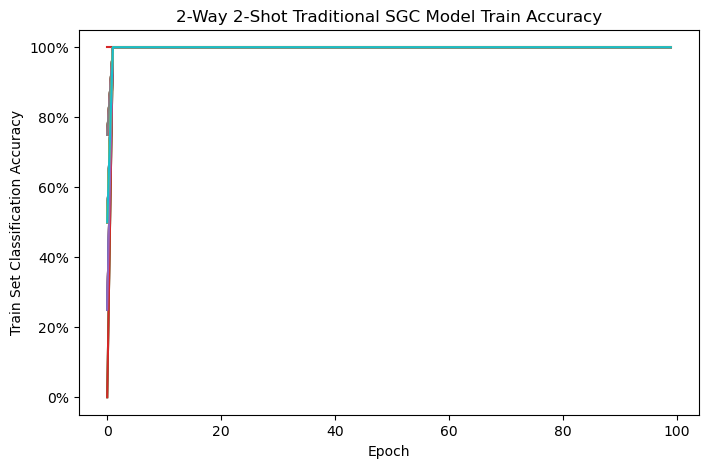

In [82]:
# Plot evolution of training accuracy
plt.figure(figsize=(8,5))
for lst in all_train_accs:
    plt.plot(lst)

plt.title("{}-Way {}-Shot Traditional SGC Model Train Accuracy".format(num_ways, num_shots))
plt.xlabel("Epoch")
plt.ylabel("Train Set Classification Accuracy")
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 

plt.show()

/tmp/ipykernel_28453/4202757991.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


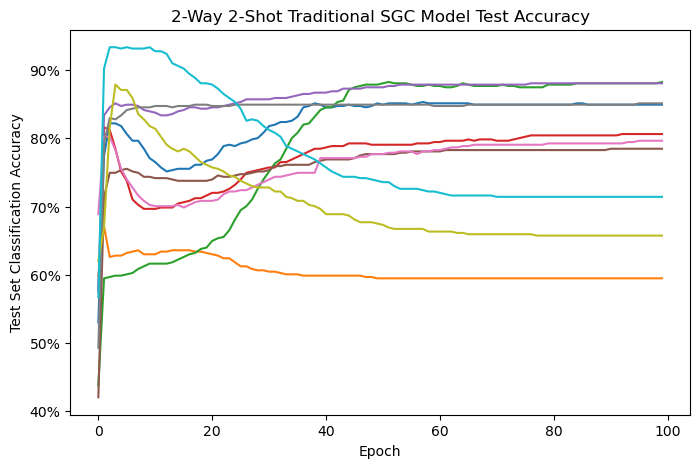

In [83]:
# Plot evolution of test accuracy 
plt.figure(figsize=(8,5))
for lst in all_test_accs[:10]:
    plt.plot(lst)

plt.title("{}-Way {}-Shot Traditional SGC Model Test Accuracy".format(num_ways, num_shots))
plt.xlabel("Epoch")
plt.ylabel("Test Set Classification Accuracy")
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 

plt.show()

/tmp/ipykernel_28453/2378589325.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


Text(0.6722136747837066, 15.120000000000001, 'Mean: 78.2%')

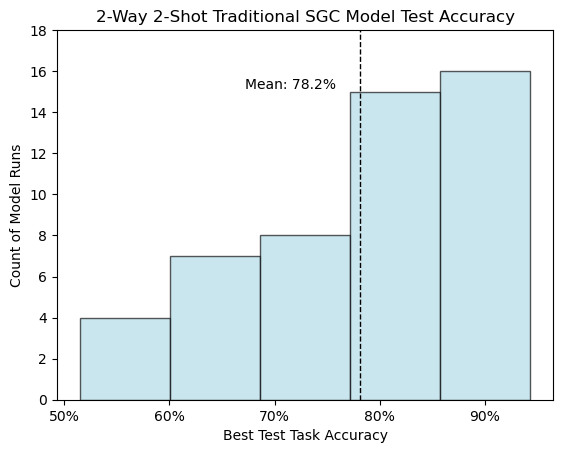

In [84]:
# Plot histogram of best accuracy achieved with mean
best_test_accs = np.array(best_test_accs)

result = plt.hist(best_test_accs, bins=5, color='lightblue', edgecolor='k', alpha=0.65)
plt.axvline(best_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

plt.title("{}-Way {}-Shot Traditional SGC Model Test Accuracy".format(num_ways, num_shots))
plt.xlabel("Best Test Task Accuracy")
plt.ylabel("Count of Model Runs")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0,20,2))
plt.text(best_test_accs.mean()*0.86, max_ylim*0.9, 
         'Mean: {:.1%}'.format(best_test_accs.mean()))

/tmp/ipykernel_28453/1805844587.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


Text(0.5642434423446655, 12.285, 'Mean: 68.8%')

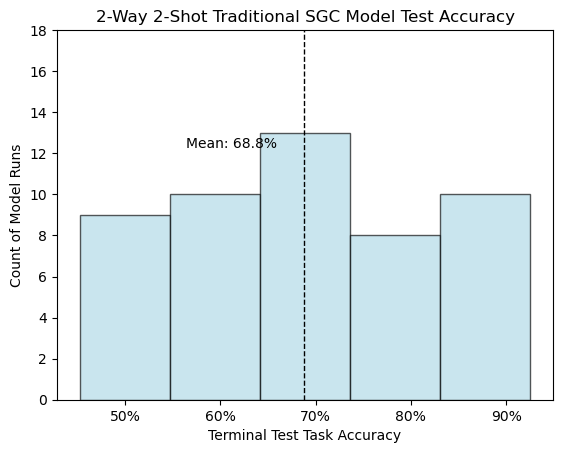

In [85]:
# Plot histogram of terminal accuracy achieved with mean
terminal_test_accs = np.array(terminal_test_accs)

result = plt.hist(terminal_test_accs, bins=5, color='lightblue', edgecolor='k', alpha=0.65)
plt.axvline(terminal_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

plt.title("{}-Way {}-Shot Traditional SGC Model Test Accuracy".format(num_ways, num_shots))
plt.xlabel("Terminal Test Task Accuracy")
plt.ylabel("Count of Model Runs")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0,20,2))
plt.text(terminal_test_accs.mean()*0.82, max_ylim*0.9, 
         'Mean: {:.1%}'.format(terminal_test_accs.mean()))

In [86]:
print('Best Accs Standard Dev: {}'.format(np.std(best_test_accs)))
print('Terminal Accs Standard Dev: {}'.format(np.std(terminal_test_accs)))

Best Accs Standard Dev: 0.11486270278692245
Terminal Accs Standard Dev: 0.1375776356967642


### Input hyperparameters, run traditional graph learning for a 2-way, 3-shot task

In [87]:
# Input parameters here
num_shots = 3
num_ways = 2
num_training_epochs = 100

In [88]:
# Save the evolution of training, test accuracies, best overall test accuracy,
# and terminal test accuracy for the specified number of runs

all_train_accs = []
all_test_accs = []
best_test_accs = []
terminal_test_accs = []

for i in range(num_runs):
    cur_train_accs, cur_test_accs, cur_best_acc = training_loop(num_shots, num_training_epochs, 
                                                                test_classes, num_ways, 
                                                                train_shots = three_shot_runs[i][0], 
                                                                test_nodes = three_shot_runs[i][1])
    all_train_accs.append(cur_train_accs)
    all_test_accs.append(cur_test_accs)
    best_test_accs.append(cur_best_acc)
    terminal_test_accs.append(cur_test_accs[-1])

### Create plots and metrics for the 2-way, 3-shot task

/tmp/ipykernel_28453/4167386516.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


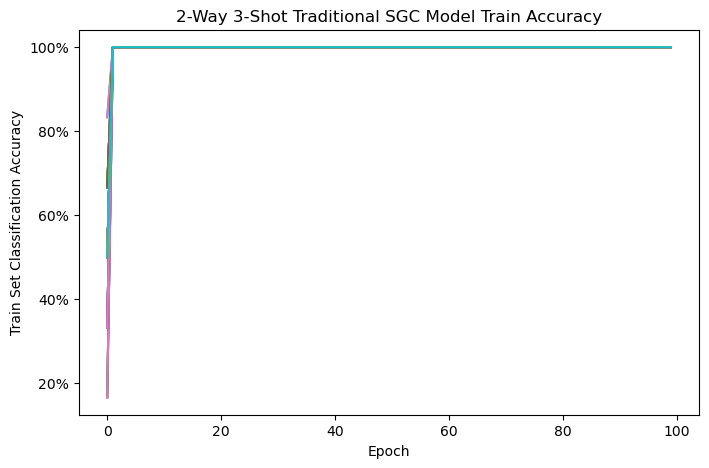

In [89]:
# Plot evolution of training accuracy
plt.figure(figsize=(8,5))
for lst in all_train_accs:
    plt.plot(lst)

plt.title("{}-Way {}-Shot Traditional SGC Model Train Accuracy".format(num_ways, num_shots))
plt.xlabel("Epoch")
plt.ylabel("Train Set Classification Accuracy")
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 

plt.show()

/tmp/ipykernel_28453/4202757991.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


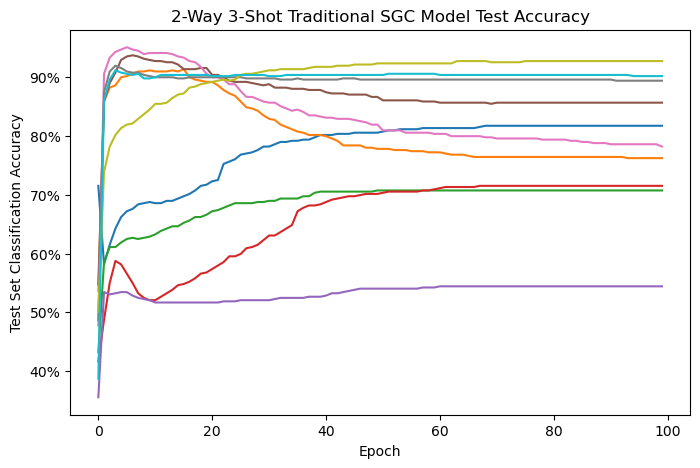

In [90]:
# Plot evolution of test accuracy 
plt.figure(figsize=(8,5))
for lst in all_test_accs[:10]:
    plt.plot(lst)

plt.title("{}-Way {}-Shot Traditional SGC Model Test Accuracy".format(num_ways, num_shots))
plt.xlabel("Epoch")
plt.ylabel("Test Set Classification Accuracy")
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 

plt.show()

/tmp/ipykernel_28453/2347218974.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


Text(0.6932354092597961, 18.900000000000002, 'Mean: 79.7%')

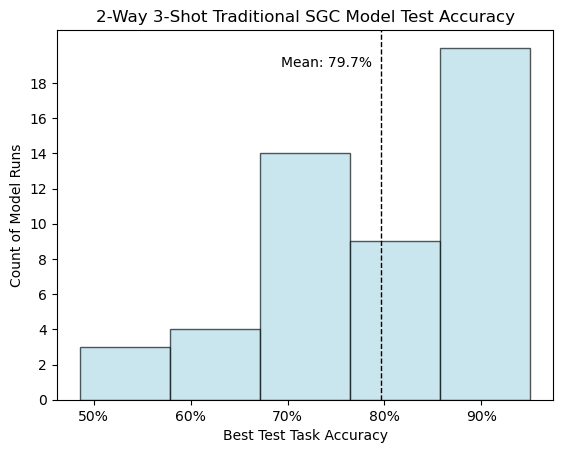

In [91]:
# Plot histogram of best accuracy achieved with mean
best_test_accs = np.array(best_test_accs)

result = plt.hist(best_test_accs, bins=5, color='lightblue', edgecolor='k', alpha=0.65)
plt.axvline(best_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

plt.title("{}-Way {}-Shot Traditional SGC Model Test Accuracy".format(num_ways, num_shots))
plt.xlabel("Best Test Task Accuracy")
plt.ylabel("Count of Model Runs")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0,20,2))
plt.text(best_test_accs.mean()*0.87, max_ylim*0.9, 
         'Mean: {:.1%}'.format(best_test_accs.mean()))

Text(0.6343147337734699, 16.065, 'Mean: 74.6%')

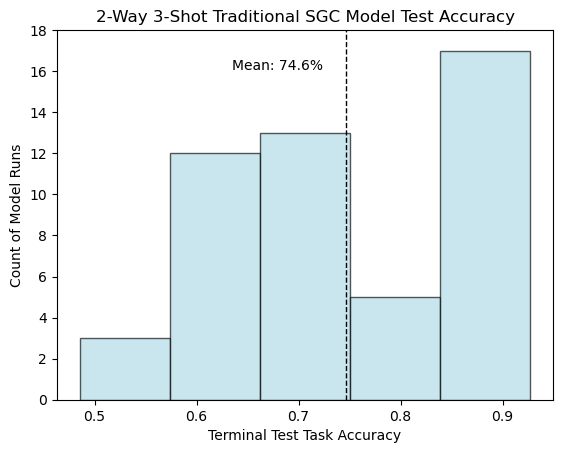

In [92]:
# Plot histogram of terminal accuracy achieved with mean
terminal_test_accs = np.array(terminal_test_accs)

result = plt.hist(terminal_test_accs, bins=5, color='lightblue', edgecolor='k', alpha=0.65)
plt.axvline(terminal_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

plt.title("{}-Way {}-Shot Traditional SGC Model Test Accuracy".format(num_ways, num_shots))
plt.xlabel("Terminal Test Task Accuracy")
plt.ylabel("Count of Model Runs")

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0,20,2))
plt.text(terminal_test_accs.mean()*0.85, max_ylim*0.9, 
         'Mean: {:.1%}'.format(terminal_test_accs.mean()))

In [93]:
print('Best Accs Standard Dev: {}'.format(np.std(best_test_accs)))
print('Terminal Accs Standard Dev: {}'.format(np.std(terminal_test_accs)))

Best Accs Standard Dev: 0.1227034330368042
Terminal Accs Standard Dev: 0.12403660243711968


## IV. MAML with graph learning

### Create the MAML inner loop

In [94]:
def maml_inner_training_loop(outer_model, outer_optimizer, 
                             num_shots, num_epochs, classes):
      
    # Reinitialize the inner model parameters from the outer model
    inner_model = SGC(g.ndata['feat'].shape[1], 64, num_ways)
    inner_model.conv1.weight = torch.nn.Parameter(torch.clone(outer_model.conv1.weight))
    inner_model.conv2.weight = torch.nn.Parameter(torch.clone(outer_model.conv2.weight))

    inner_optimizer = torch.optim.Adam(inner_model.parameters(), lr=0.01)
    inner_features = torch.clone(g.ndata['feat'])
    inner_labels = torch.clone(g.ndata['label'])

    # Relabel the classes, obtain training shots
    inner_train_shots = []
    inner_test_nodes = []
    for i, class_lab in enumerate(classes): 
      inner_labels[g.ndata['label']==class_lab] = i
      cur_train_shots, cur_test_nodes = gen_task(g, label_num = class_lab, 
                                                 num_shots = num_shots)
      inner_train_shots.append(cur_train_shots)
      inner_test_nodes.append(cur_test_nodes)

    # Get all training shots and query examples
    inner_all_shots = np.concatenate(inner_train_shots)
    inner_all_query = np.concatenate(inner_test_nodes)

    for epoch in range(num_inner_steps):
        # Forward
        inner_logits = inner_model(g, inner_features)

        # Compute prediction
        inner_pred = inner_logits.argmax(1)

        # Compute loss for the given shots 
        inner_loss = F.cross_entropy(inner_logits[inner_all_shots], inner_labels[inner_all_shots])

        # Backward pass on the inner loop model
        inner_optimizer.zero_grad()
        inner_loss.backward(create_graph=True)
        inner_optimizer.step()

    # Get the logits after all the inner loop updates 
    inner_logits = inner_model(g, inner_features)

    # Get the loss on the query set
    outer_loss = F.cross_entropy(inner_logits[inner_all_query], inner_labels[inner_all_query])

    # Avoid memory leak when using .backward() and create_graph = True
    for param in inner_model.parameters():
        param.grad = None
    
    return outer_loss

### Create the MAML test loop

In [95]:
def maml_test_loop(num_shots, test_classes, outer_model,
                   all_shots, all_query, outer_labels, outer_features,
                   num_inner_steps):  
    
    model = outer_model
  
    optimizer_test = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(num_inner_steps):
        # Forward
        logits = model(g, outer_features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss for the given shots 
        loss = F.cross_entropy(logits[all_shots], outer_labels[all_shots])

        # Backward
        optimizer_test.zero_grad()
        loss.backward()
        optimizer_test.step()

    # Compute accuracy on training/validation/test
    train_acc = (pred[all_shots] == outer_labels[all_shots]).float().mean()
    test_acc = (pred[all_query] == outer_labels[all_query]).float().mean()
    
    return train_acc, test_acc

### Create the MAML outer training loop

In [96]:
def maml_outer_training_loop(num_outer_loops, num_inner_steps, num_shots, num_ways,
                             test_classes, train_classes, outer_train_shots, outer_test_nodes):
    
    outer_model = SGC(g.ndata['feat'].shape[1], 64, 2)
    outer_optimizer = torch.optim.Adam(outer_model.parameters(), lr=0.01)

    outer_train_accs = []
    outer_test_accs = []
    outer_best_test_acc = 0 

    outer_labels = torch.clone(g.ndata['label'])
    outer_features = torch.clone(g.ndata['feat'])

    # Generate the test task
    for i, class_lab in enumerate(test_classes): 
      outer_labels[g.ndata['label']==class_lab] = i

    outer_all_shots = np.concatenate(outer_train_shots)
    outer_all_query = np.concatenate(outer_test_nodes)

    for i in np.arange(num_outer_loops):
        # Choose classes for the inner loop query set
        cur_classes = np.random.choice(train_classes, num_ways)

        # Run the inner loop for the training task
        outer_loss = maml_inner_training_loop(outer_model = outer_model,
                                              outer_optimizer = outer_optimizer,
                                              num_shots = num_shots,
                                              num_epochs = num_inner_steps,
                                              classes = cur_classes)
        
        # Do the outer loop update 
        outer_optimizer.zero_grad()
        outer_loss.backward(retain_graph = False)
        outer_optimizer.step()
        
        # Evaluate on the outer loop test task
        cur_train_acc, cur_test_acc = maml_test_loop(num_shots, test_classes, outer_model,
                                                     outer_all_shots, outer_all_query, outer_labels,
                                                     outer_features, num_inner_steps)
        
        outer_train_accs.append(cur_train_acc.detach().item())
        outer_test_accs.append(cur_test_acc.detach().item())
        
        # Save the best validation accuracy and the corresponding test accuracy
        if outer_best_test_acc < cur_test_acc:
            outer_best_test_acc = cur_test_acc.detach().item()
    
    # Avoid memory leak when using .backward() and create_graph = True
    for param in outer_model.parameters():
        param.grad = None

    # Return the evolution of performance on the test task
    return outer_train_accs, outer_test_accs, outer_best_test_acc
    

### Input hyperparameters, run MAML w/ graph learning for a 2-way, 1-shot task

In [97]:
# Input parameters here
num_outer_loops = 50
num_inner_steps = 3
num_shots = 1
num_ways = 2
train_classes = (0, 2, 3, 4, 6)

In [98]:
# Save the evolution of training, test accuracies, best overall test accuracy,
# and terminal test accuracy for the specified number of runs

maml_train_accs = []
maml_test_accs = []
maml_best_test_accs = []
maml_terminal_test_accs = []

for i in range(num_runs):
    cur_train_accs, cur_test_accs, cur_best_acc = maml_outer_training_loop(num_outer_loops, num_inner_steps, num_shots, num_ways,
                                                  test_classes, train_classes, one_shot_runs[i][0], one_shot_runs[i][1])
    maml_train_accs.append(cur_train_accs)
    maml_test_accs.append(cur_test_accs)
    maml_best_test_accs.append(cur_best_acc)
    maml_terminal_test_accs.append(cur_test_accs[-1])

### Create plots and metrics for a 2-way, 1-shot task

/tmp/ipykernel_28453/3091362644.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


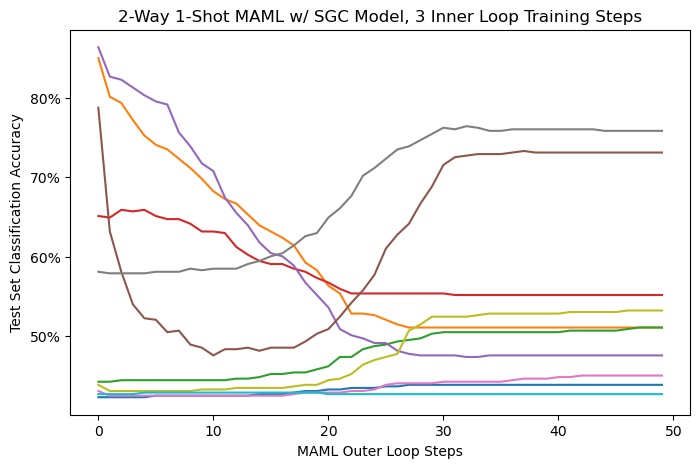

In [99]:
# Plot evolution of test accuracy over outer loop steps for 10 runs
plt.figure(figsize=(8,5))
for lst in maml_test_accs[:10]:
    plt.plot(lst)

plt.title("{}-Way {}-Shot MAML w/ SGC Model, 3 Inner Loop Training Steps".format(num_ways, num_shots))
plt.xlabel("MAML Outer Loop Steps")
plt.ylabel("Test Set Classification Accuracy")
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 

plt.show()

/tmp/ipykernel_28453/406647885.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


Text(0.6399259253144264, 11.34, 'Mean: 67.4%')

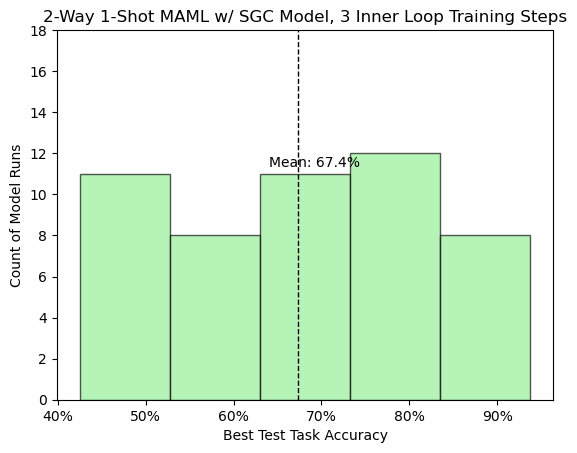

In [100]:
# Plot histogram of best accuracy achieved with mean
maml_best_test_accs = np.array(maml_best_test_accs)

result = plt.hist(maml_best_test_accs, bins=5, color='lightgreen', edgecolor='k', alpha=0.65)
plt.axvline(maml_best_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0,20,2))

plt.title("{}-Way {}-Shot MAML w/ SGC Model, 3 Inner Loop Training Steps".format(num_ways, num_shots))
plt.xlabel("Best Test Task Accuracy")
plt.ylabel("Count of Model Runs")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

plt.text(maml_best_test_accs.mean()* 0.95, max_ylim*0.9, 
         'Mean: {:.1%}'.format(maml_best_test_accs.mean()))

/tmp/ipykernel_28453/888565154.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


Text(0.4907290439605714, 14.175, 'Mean: 61.3%')

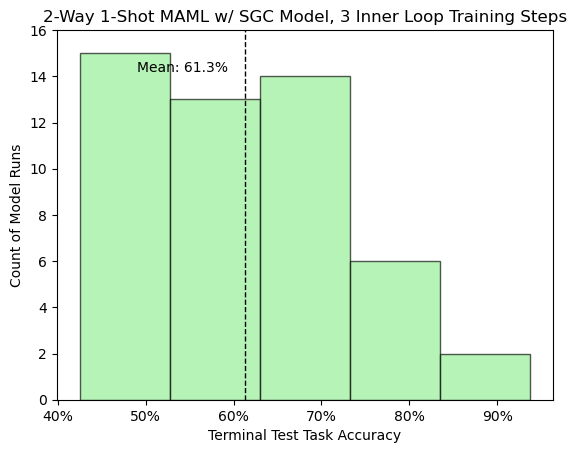

In [101]:
# Plot histogram of terminal accuracy achieved with mean
maml_terminal_test_accs = np.array(maml_terminal_test_accs)

result = plt.hist(maml_terminal_test_accs, bins=5, color='lightgreen', edgecolor='k', alpha=0.65)
plt.axvline(maml_terminal_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

plt.title("{}-Way {}-Shot MAML w/ SGC Model, 3 Inner Loop Training Steps".format(num_ways, num_shots))
plt.xlabel("Terminal Test Task Accuracy")
plt.ylabel("Count of Model Runs")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0, 18, 2))
plt.text(maml_terminal_test_accs.mean()*0.80, max_ylim*0.9, 
         'Mean: {:.1%}'.format(maml_terminal_test_accs.mean()))

In [102]:
print('Best Accs Standard Dev: {}'.format(np.std(maml_best_test_accs)))
print('Terminal Accs Standard Dev: {}'.format(np.std(maml_terminal_test_accs)))

Best Accs Standard Dev: 0.14673852507398205
Terminal Accs Standard Dev: 0.1301504632490752


### Input hyperparameters, run MAML w/ graph learning for a 2-way, 2-shot task

In [103]:
# Input parameters here
num_outer_loops = 50
num_inner_steps = 3
num_shots = 2
num_ways = 2
train_classes = (0, 2, 3, 4, 6)

In [104]:
# Save the evolution of training, test accuracies, best overall test accuracy,
# and terminal test accuracy for the specified number of runs

maml_train_accs = []
maml_test_accs = []
maml_best_test_accs = []
maml_terminal_test_accs = []

for i in range(num_runs):
    cur_train_accs, cur_test_accs, cur_best_acc = maml_outer_training_loop(num_outer_loops, num_inner_steps, num_shots, num_ways,
                                                  test_classes, train_classes, two_shot_runs[i][0], two_shot_runs[i][1])
    maml_train_accs.append(cur_train_accs)
    maml_test_accs.append(cur_test_accs)
    maml_best_test_accs.append(cur_best_acc)
    maml_terminal_test_accs.append(cur_test_accs[-1])

### Create plots and metrics for the 2-way, 2-shot task

/tmp/ipykernel_28453/3091362644.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


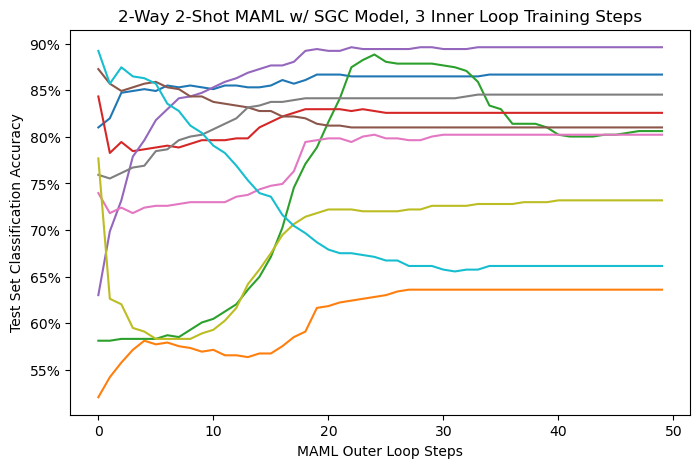

In [105]:
# Plot evolution of test accuracy over outer loop steps for 10 runs
plt.figure(figsize=(8,5))
for lst in maml_test_accs[:10]:
    plt.plot(lst)

plt.title("{}-Way {}-Shot MAML w/ SGC Model, 3 Inner Loop Training Steps".format(num_ways, num_shots))
plt.xlabel("MAML Outer Loop Steps")
plt.ylabel("Test Set Classification Accuracy")
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 

plt.show()

/tmp/ipykernel_28453/406647885.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


Text(0.7321135005950928, 17.955, 'Mean: 77.1%')

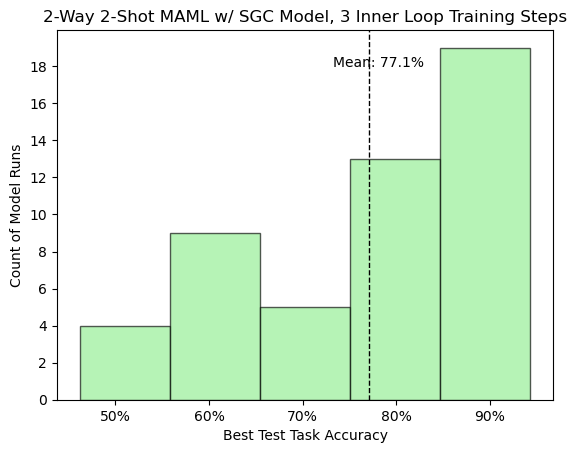

In [106]:
# Plot histogram of best accuracy achieved with mean
maml_best_test_accs = np.array(maml_best_test_accs)

result = plt.hist(maml_best_test_accs, bins=5, color='lightgreen', edgecolor='k', alpha=0.65)
plt.axvline(maml_best_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0,20,2))

plt.title("{}-Way {}-Shot MAML w/ SGC Model, 3 Inner Loop Training Steps".format(num_ways, num_shots))
plt.xlabel("Best Test Task Accuracy")
plt.ylabel("Count of Model Runs")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

plt.text(maml_best_test_accs.mean()* 0.95, max_ylim*0.9, 
         'Mean: {:.1%}'.format(maml_best_test_accs.mean()))

/tmp/ipykernel_28453/888565154.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


Text(0.546066535949707, 11.34, 'Mean: 68.3%')

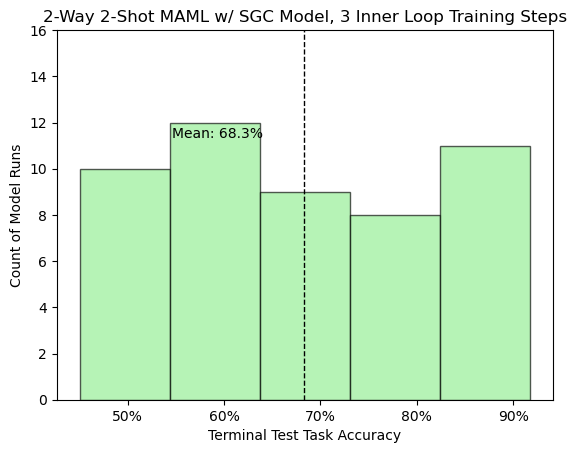

In [107]:
# Plot histogram of terminal accuracy achieved with mean
maml_terminal_test_accs = np.array(maml_terminal_test_accs)

result = plt.hist(maml_terminal_test_accs, bins=5, color='lightgreen', edgecolor='k', alpha=0.65)
plt.axvline(maml_terminal_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

plt.title("{}-Way {}-Shot MAML w/ SGC Model, 3 Inner Loop Training Steps".format(num_ways, num_shots))
plt.xlabel("Terminal Test Task Accuracy")
plt.ylabel("Count of Model Runs")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0, 18, 2))
plt.text(maml_terminal_test_accs.mean()*0.80, max_ylim*0.9, 
         'Mean: {:.1%}'.format(maml_terminal_test_accs.mean()))

In [108]:
print('Best Accs Standard Dev: {}'.format(np.std(maml_best_test_accs)))
print('Terminal Accs Standard Dev: {}'.format(np.std(maml_terminal_test_accs)))

Best Accs Standard Dev: 0.13728678260325325
Terminal Accs Standard Dev: 0.13916577554928555


### Input hyperparameters, run MAML w/ graph learning for a 2-way, 3-shot task

In [109]:
# Input parameters here
num_outer_loops = 50
num_inner_steps = 3
num_shots = 3
num_ways = 2
train_classes = (0, 2, 3, 4, 6)

In [110]:
# Save the evolution of training, test accuracies, best overall test accuracy,
# and terminal test accuracy for the specified number of runs

maml_train_accs = []
maml_test_accs = []
maml_best_test_accs = []
maml_terminal_test_accs = []

for i in range(num_runs):
    cur_train_accs, cur_test_accs, cur_best_acc = maml_outer_training_loop(num_outer_loops, num_inner_steps, num_shots, num_ways,
                                                  test_classes, train_classes, three_shot_runs[i][0], three_shot_runs[i][1])
    maml_train_accs.append(cur_train_accs)
    maml_test_accs.append(cur_test_accs)
    maml_best_test_accs.append(cur_best_acc)
    maml_terminal_test_accs.append(cur_test_accs[-1])

### Create plots and metrics for the 2-way, 3-shot task

/tmp/ipykernel_28453/3291999149.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


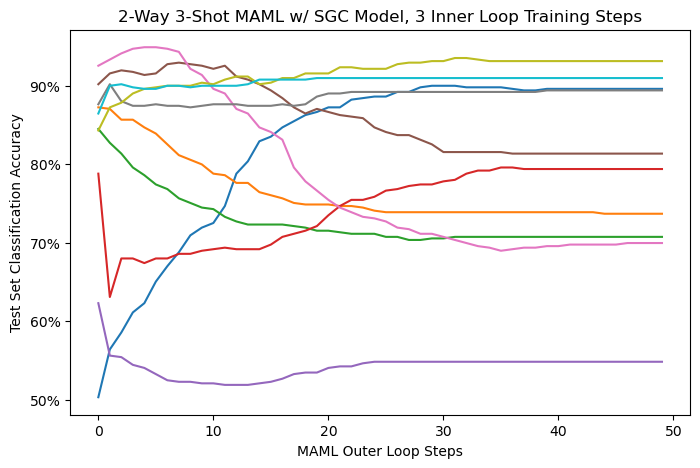

In [111]:
# Plot evolution of test accuracy over outer loop steps
plt.figure(figsize=(8,5))
for lst in maml_test_accs[:10]:
    plt.plot(lst)

plt.title("{}-Way {}-Shot MAML w/ SGC Model, 3 Inner Loop Training Steps".format(num_ways, num_shots))
plt.xlabel("MAML Outer Loop Steps")
plt.ylabel("Test Set Classification Accuracy")
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 

plt.show()

/tmp/ipykernel_28453/1479621866.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


Text(0.6899220032691955, 21.735, 'Mean: 81.2%')

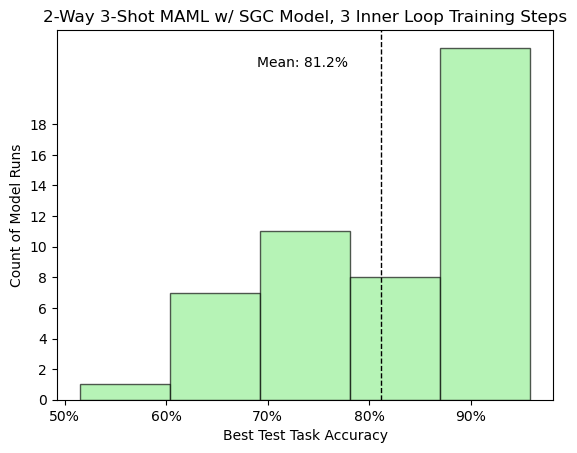

In [112]:
# Plot histogram of best accuracy achieved with mean
maml_best_test_accs = np.array(maml_best_test_accs)

result = plt.hist(maml_best_test_accs, bins=5, color='lightgreen', edgecolor='k', alpha=0.65)
plt.axvline(maml_best_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

plt.title("{}-Way {}-Shot MAML w/ SGC Model, 3 Inner Loop Training Steps".format(num_ways, num_shots))
plt.xlabel("Best Test Task Accuracy")
plt.ylabel("Count of Model Runs")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0,20,2))
plt.text(maml_best_test_accs.mean()*0.85, max_ylim*0.9, 
         'Mean: {:.1%}'.format(maml_best_test_accs.mean()))

/tmp/ipykernel_28453/1249520495.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()])


Text(0.5992339916229249, 16.065, 'Mean: 74.9%')

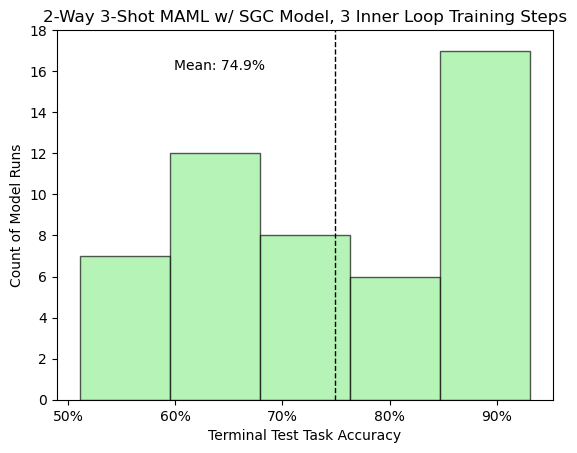

In [113]:
# Plot histogram of terminal accuracy achieved with mean
maml_terminal_test_accs = np.array(maml_terminal_test_accs)

result = plt.hist(maml_terminal_test_accs, bins=5, color='lightgreen', edgecolor='k', alpha=0.65)
plt.axvline(maml_terminal_test_accs.mean(), color='k', linestyle='dashed', linewidth=1)

plt.title("{}-Way {}-Shot MAML w/ SGC Model, 3 Inner Loop Training Steps".format(num_ways, num_shots))
plt.xlabel("Terminal Test Task Accuracy")
plt.ylabel("Count of Model Runs")
plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

min_ylim, max_ylim = plt.ylim()
plt.yticks(np.arange(0,20,2))
plt.text(maml_terminal_test_accs.mean()*0.80, max_ylim*0.9, 
         'Mean: {:.1%}'.format(maml_terminal_test_accs.mean()))

In [114]:
print('Best Accs Standard Dev: {}'.format(np.std(maml_best_test_accs)))
print('Terminal Accs Standard Dev: {}'.format(np.std(maml_terminal_test_accs)))

Best Accs Standard Dev: 0.11063702409030965
Terminal Accs Standard Dev: 0.12930341489655903
